## Two phase flow.
### pezoflow equation.

$$\frac{\partial \rho_w S_w m}{\partial t} + \frac{\partial}{\partial x}(\rho_w W_w)=0$$
$$\frac{\partial \rho_o S_o m}{\partial t} + \frac{\partial}{\partial x}(\rho_o W_o)=0$$
$$W_w=-\frac{k_{rw} k}{\mu_w}\frac{\partial p}{\partial x}$$
$$W_o=-\frac{k_{ro} k}{\mu_o}\frac{\partial p}{\partial x}$$
$$S_o+S_w=1$$
$$m(p)=m_0+\beta_r*(p-p_0)$$
$$\rho_{w,o}(p) = \rho_{w0, o0}(1 + \beta_{w,o}*(p-p_0))$$

$$x\in[0,L]$$
$$t\in[0,T]$$

*Initial and boundary conditions*
$$p(x, t=0)=p_0$$
$$S_w(x, t=0)=S_{w0}$$
$$W_w(x=0, t)=\frac{Q}{S}$$
$$S_w(x=0, t)=1$$
$$p(x=L, t)=p_0$$

1.
$$\rho_w m \frac{\partial S_w}{\partial t} + \rho_w S_w \frac{\partial m}{\partial t} + m S_w \frac{\partial \rho_w}{\partial t} - \frac{\partial}{\partial x}(\rho_w\frac{k_{rw} k}{\mu_w}\frac{\partial p}{\partial x})=0 $$
$$\rho_o m \frac{\partial S_o}{\partial t} + \rho_w S_o \frac{\partial m}{\partial t} + m S_o \frac{\partial \rho_o}{\partial t} - \frac{\partial}{\partial x}(\rho_w\frac{k_{ro} k}{\mu_o}\frac{\partial p}{\partial x})=0 $$

2.
$$ m \frac{\partial S_w}{\partial t} + S_w \beta_r \frac{\partial p}{\partial t} + m S_w \frac{\rho_{w0}}{\rho_w} \beta_w\frac{\partial p}{\partial t} - \frac{1}{\rho_w}\frac{\partial}{\partial x}(\rho_w\frac{k_{rw} k}{\mu_w}\frac{\partial p}{\partial x})=0 $$
$$m \frac{\partial S_o}{\partial t} +  S_o \beta_r \frac{\partial p}{\partial t} + m S_o \frac{\rho_{o0}}{\rho_o} \beta_o\frac{\partial p}{\partial t} - \frac{1}{\rho_o}\frac{\partial}{\partial x}(\rho_o\frac{k_{ro} k}{\mu_o}\frac{\partial p}{\partial x})=0 $$


3. summarize
$$\frac{\partial p}{\partial t}(S_w \beta_r+S_o \beta_r + m S_w \frac{\rho_{w0}}{\rho_w} \beta_w+m S_o \frac{\rho_{o0}}{\rho_o} \beta_o) - \frac{\partial}{\partial x}(k(\frac{k_{rw} \rho_w}{\mu_w}+\frac{k_{ro} \rho_o}{\mu_o})\frac{\partial p}{\partial x})=0 $$
$$\rho_w m \frac{\partial S_w}{\partial t} + \frac{\partial p}{\partial t}(\rho_w S_w \beta_r + m S_w \rho_{w0} \beta_w) - \frac{\partial}{\partial x}(\rho_w\frac{k_{rw} k}{\mu_w}\frac{\partial p}{\partial x})=0 $$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.optimize import newton_krylov, minimize
from scipy.ndimage import gaussian_filter1d
from weno4 import weno4
import torch

In [4]:
mu_h = 5e-3
mu_o = 2e-3
glad = 0.00005
G = 4.4e6

mu_water = 8e-4

k = 10e-15
Q = 0.4/86400

t_0 = 0
T = 1*86400
nt = 1500
time = np.linspace(t_0, T, nt)
dt = time[1]-time[0]
tt = 0.3*86400
tt = time.flat[np.abs(time - tt).argmin()]
pow_n = 4

x_0 = 0
L = 1
nx = 100
x = np.linspace(0, L, nx)

dx = x[1]-x[0]

p0 = 1e+6
m0 = 0.2

beta_r = 1e-10

rho_w0 = 1000
beta_w = 0

rho_o0 = 800
beta_o = 0

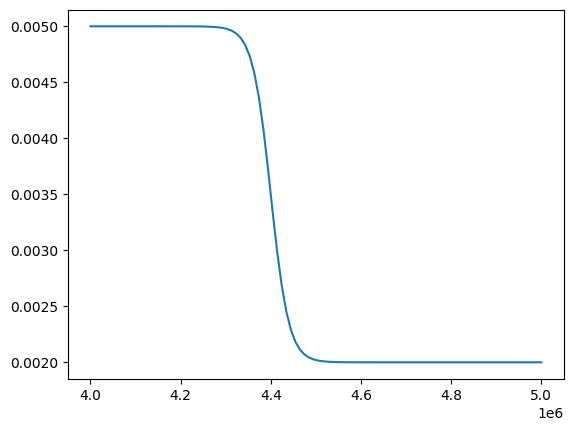

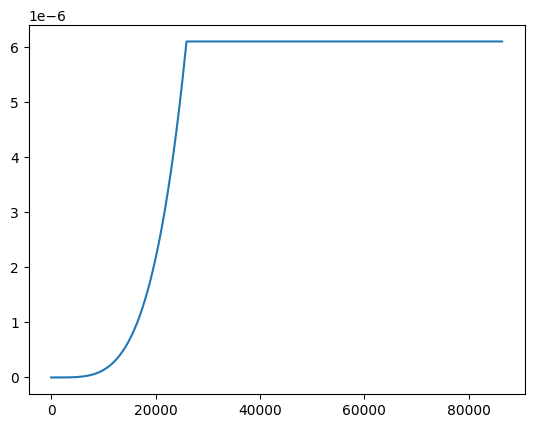

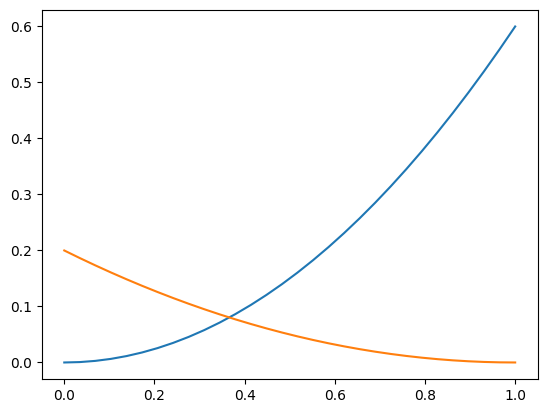

In [5]:
def expit(x):
    return 1 / (1 + np.exp(-x))

mu_oil_x = np.zeros(nx)+mu_h

def mu_oil(grad, mu_oil_x):
    grad = abs(grad)
    mu = (mu_h-mu_o) * expit (glad * (-grad + G)) + mu_o
    res = np.where(mu < mu_oil_x, mu, mu_oil_x)
    return res

plt.plot(np.linspace(4e+6, 5e+6, nx), mu_oil(np.linspace(4e+6, 5e+6, nx), mu_oil_x))
plt.show()

def rate(t):
    n = pow_n
    a = Q*(T-t_0) / (tt**(n+1)/(n+1) + tt**n*(T-tt))
    return np.where(t<tt,a*t**(n),a*tt**(n))

plt.plot(time, rate(time))
plt.show()

def m(p):
    return m0 + beta_r*(p-p0)

def rho_w(p):
    return rho_w0*(1+beta_w*(p-p0))

def rho_o(p):
    return rho_o0*(1+beta_o*(p-p0))

k_water = lambda x: 0.6*(x)**2
k_oil = lambda x: 0.2*(x-1)**2

plt.plot(np.linspace(0, 1, 30), k_water(np.linspace(0, 1, 30)))
plt.plot(np.linspace(0, 1, 30), k_oil(np.linspace(0, 1, 30)))
plt.show()

$$m\frac{\partial S_w}{\partial t}(\rho_w -\rho_o) + \frac{\partial p}{\partial t}(\rho_w S_w \beta_r+\rho_o S_o \beta_r + m S_w \rho_{w0} \beta_w+m S_o \rho_{o0} \beta_o) - \frac{\partial}{\partial x}(k(\frac{k_{rw} \rho_w}{\mu_w}+\frac{k_{ro} \rho_o}{\mu_o})\frac{\partial p}{\partial x})=0 $$
$$\rho_w m \frac{\partial S_w}{\partial t} + \frac{\partial p}{\partial t}(\rho_w S_w \beta_r + m S_w \rho_{w0} \beta_w) - \frac{\partial}{\partial x}(\rho_w\frac{k_{rw} k}{\mu_w}\frac{\partial p}{\partial x})=0 $$

$$\frac{\partial S_w}{\partial t} + \frac{\partial p}{\partial t}(S_w \beta_r /m + S_w \rho_{w0}/\rho_w \beta_w) - \frac{\partial}{\partial x}(\rho_w\frac{k_{rw} k}{\mu_w}\frac{\partial p}{\partial x})/\rho_w m=0 $$

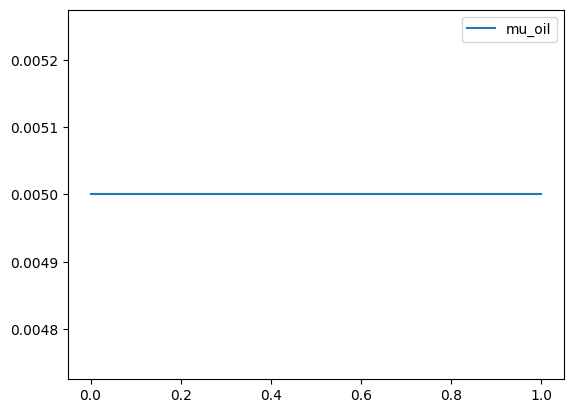

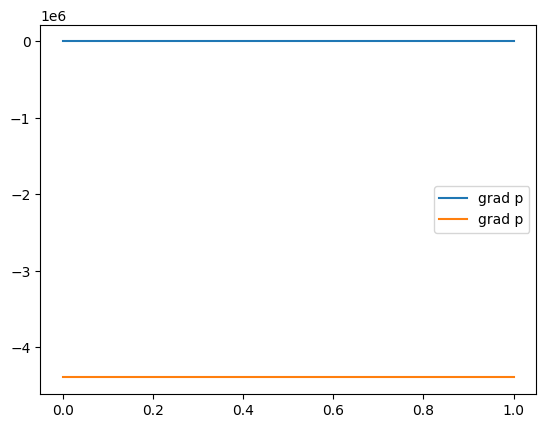

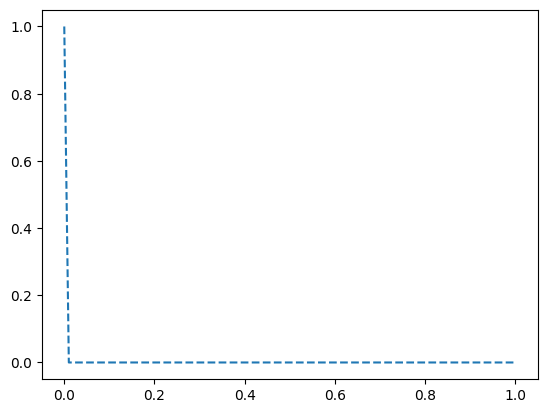

c:\Users\damir.aminev\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\optimize\_nonlin.py:367: RuntimeWarning: invalid value encountered in double_scalars
  and dx_norm/self.x_rtol <= x_norm))


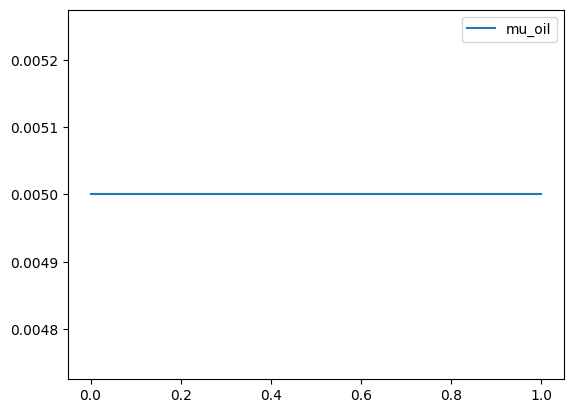

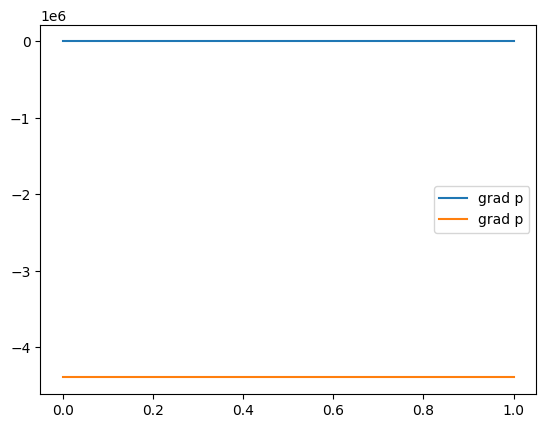

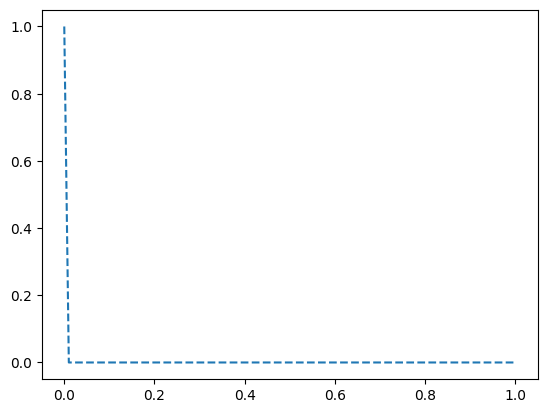

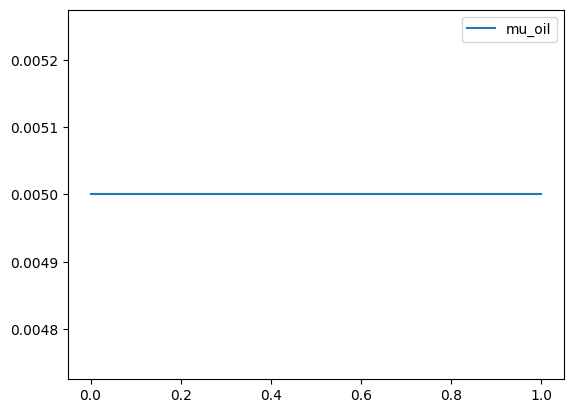

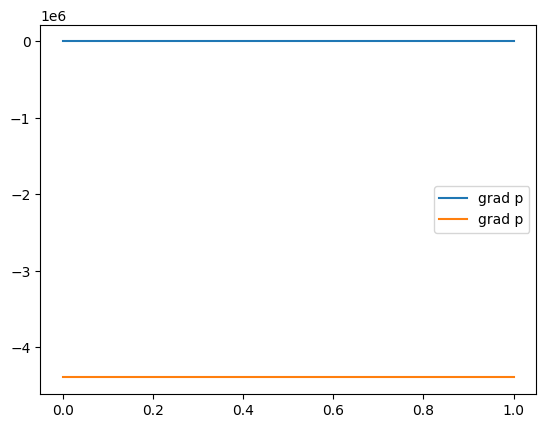

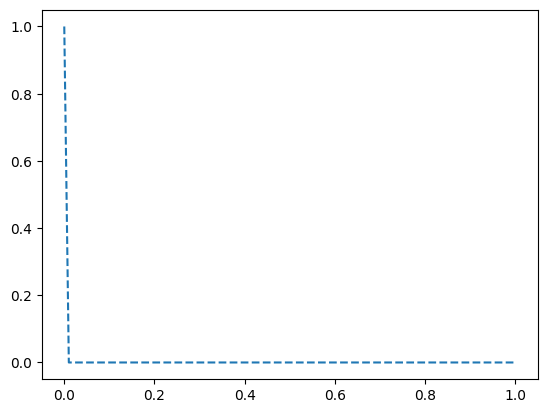

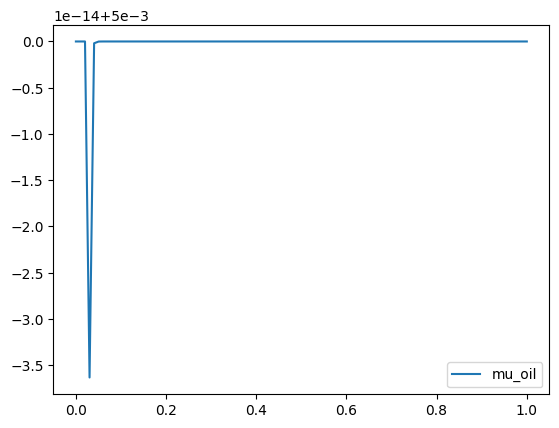

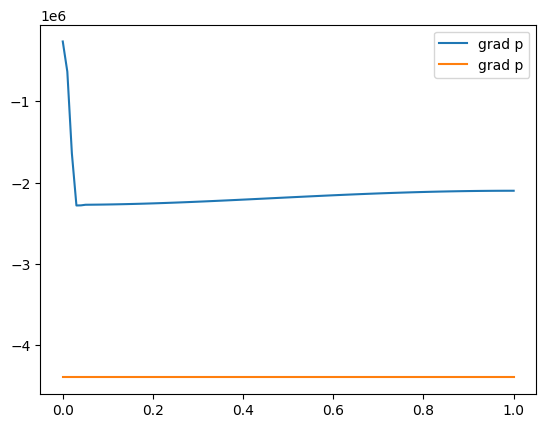

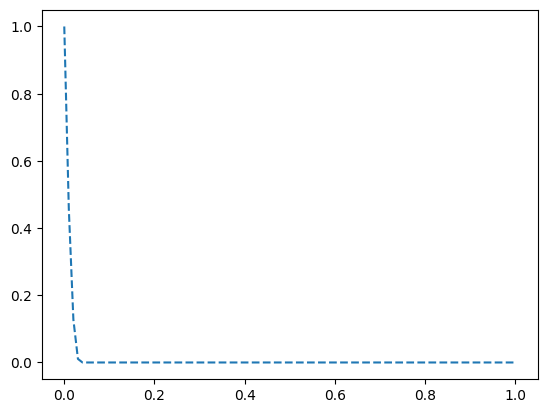

KeyboardInterrupt: 

In [9]:
# Сетка по x
x = np.linspace(0, L, nx)
mu_oil_x = np.zeros(nx)+mu_h
# Инициализация давления
p = np.zeros((nt, nx))

p[0, :] = p0

# Инициализация насыщенности
s = np.zeros((nt, nx))

s[0,:] = 0.
s[:,0] = 1

# Функция проводимости
def lam_w(s,p):
    return rho_w(p)*k_water(s) / mu_water

def lam_o(s, p, grad, mu_oil_x):
    return rho_o(p)*k_oil(s) / mu_oil(grad, mu_oil_x)

def beta(s, p, grad, mu_oil_x):
    return (lam_o(s, p, grad, mu_oil_x) + lam_w(s, p)) * k
    

def residual(u_new, u_old, s_old, s_old1, mu, t, dt, dx):
    """Выражение невязки для метода Ньютона-Крылова."""
    N = len(u_new)
    res = np.zeros(N)
    grad = np.gradient(u_new, x)
    k_left = (beta(s_old1[:-2], u_new[:-2], grad[:-2], mu[:-2]) + beta(s_old1[1:-1], u_new[1:-1], grad[1:-1], mu[1:-1])) / 2
    k_right = (beta(s_old1[1:-1], u_new[1:-1], grad[1:-1], mu[1:-1]) + beta(s_old1[2:], u_new[2:], grad[2:], mu[2:])) / 2
    res[1:-1] = m(u_new[1:-1])*(rho_w(u_new[1:-1])-rho_o(u_new[1:-1]))*(s_old1[1:-1] - s_old[1:-1]) / dt +\
        (rho_w(u_new[1:-1])*s_old1[1:-1]*beta_r + rho_o(u_new[1:-1])*(1-s_old1[1:-1])*beta_r +\
         m(u_new[1:-1])*s_old1[1:-1]*rho_w0*beta_w + m(u_new[1:-1])*(1-s_old1[1:-1])*rho_o0*beta_o)*(u_new[1:-1] - u_old[1:-1]) / dt -\
         (k_right * (u_new[2:] - u_new[1:-1]) / dx**2 - k_left * (u_new[1:-1] - u_new[:-2]) / dx**2)

    # Граничные условия (Дирихле)
    res[0] = (u_new[1] - u_new[0]) / dx * k_water(s_old1[0]) / mu_water*k + rate(t)
    res[-1] = u_new[-1] - p0
    return res

# Метод Ньютона-Крылова для решения нелинейной системы
def solve_nonlinear(u_old, s_old, s_old1, mu, t, dt, dx):
    """Решение системы уравнений с использованием метода Ньютона-Крылова."""
    u_new_guess = np.copy(u_old)  # начальное предположение
    u_new = newton_krylov(lambda u_new: residual(u_new, u_old, s_old, s_old1, mu, t, dt, dx), u_new_guess, f_tol=2e-6)
    return u_new


# Параметры фракционного потока
def fw(s, p, x):
    """ Функция фракционного потока воды """
    grad = np.gradient(p, x)

    return lam_w(s, p) * k * grad

# Решение системы с использованием Ньютона-Крылова
for t, t_step in enumerate(time[:-1]):
    # решение уравнения для давления
    p_old = p[t, :].copy()
    s_old1 = s[t, :].copy()
    if t!=0:
        s_old = s[t-1, :].copy()
    else:
        s_old = s[t, :].copy()

    p_new = solve_nonlinear(p_old, s_old, s_old1, mu_oil_x, t_step, dt, dx)
    p[t+1, :] = p_new

    # решение уравнения для насыщенности
    fw_val = fw(s_old1, p_new, x)

    s_new = np.zeros_like(s[t,:])
    s_new[1:] = s_old1[1:] - (p_new[1:] - p_old[1:])*(s_old1[1:]*beta_r/m(p_new[1:])+\
                                                     s_old1[1:]*rho_w0/rho_w(p_new[1:])*beta_w) +\
                dt/dx * (fw_val[1:] - fw_val[:-1]) / (rho_w(p_new[1:])*m(p_new[1:]))

    s_new[0] = 1
    s[t+1,:] = s_new
    if t!=0:
        mu_oil_x = mu_oil(np.gradient(p_new, x), mu_oil_x)
    if t%100==0:
        # plt.plot(x, p_new, label='p')
        # plt.legend()
        # plt.show()
        plt.plot(x, mu_oil_x, label='mu_oil')
        plt.legend()
        plt.show()
        plt.plot(x, np.gradient(p_new, x), x, -np.ones_like(x)*G, label='grad p')
        plt.legend()
        plt.show()
        plt.plot(x, s_new, '--')
        plt.show()
